In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [228]:
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [229]:
iea_global = pd.read_csv("IEA GEVO 2023 data.csv")

pcts = iea_global[(iea_global['region'] == "USA")
                  & (iea_global['parameter'].str.contains("sales share"))
                  & (iea_global['mode'] == "Cars")]
pcts.head()

,region,category,parameter,mode,powertrain,year,unit,value
8767,USA,Historical,EV sales share,Cars,EV,2010,percent,0.011
8780,USA,Historical,EV sales share,Cars,EV,2011,percent,0.170
8793,USA,Historical,EV sales share,Cars,EV,2012,percent,0.410
8806,USA,Historical,EV sales share,Cars,EV,2013,percent,0.740
8819,USA,Historical,EV sales share,Cars,EV,2014,percent,0.890


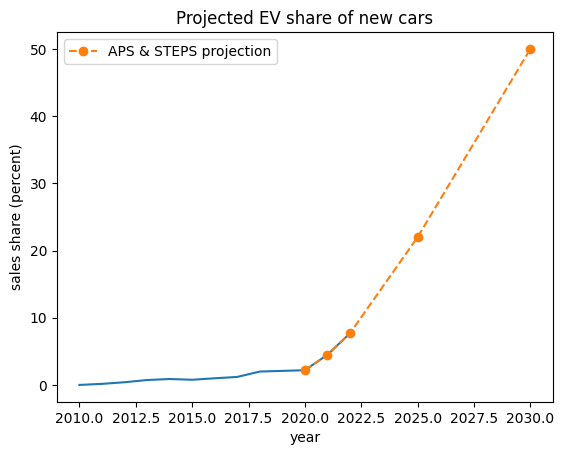

In [230]:
hist = pcts[pcts['category'] == 'Historical']
hist = hist.set_index('year')

proj = pcts[(pcts['category'] == 'Projection-APS')]
proj = proj.set_index('year')

plt.plot(hist['value'])
plt.plot(proj['value'], linestyle='--', marker='o', label="APS & STEPS projection")

plt.xlabel("year")
plt.ylabel("sales share (percent)")
plt.title("Projected EV share of new cars")

plt.legend()
plt.show()

In [231]:
xx = np.arange(2010, 2031)
xx

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030])

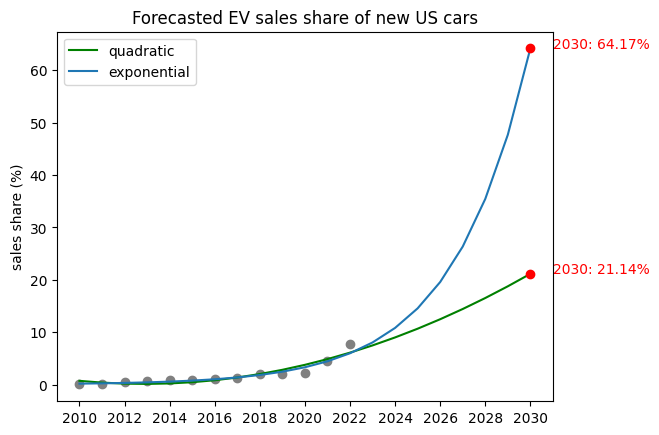

In [232]:
x, y = hist.index, hist['value']
plt.scatter(x, y, c='gray')

xx = np.arange(2010, 2031)
# quadratic
model = np.poly1d(np.polyfit(x, y, 2))
plt.plot(xx, model(xx), c='green', label="quadratic")

# exponential
# for start in np.arange(9):
#     model = np.poly1d(np.polyfit(x[start:], np.log(y[start:]), 1))
#     plt.plot(xx, np.exp(model(xx)), label=f"exponential ({2010+start})")

# plot quadratic predction
prediction_year = 2030
plt.plot(prediction_year, model(prediction_year), marker='o', c='red')
plt.text(prediction_year + 1, model(prediction_year), s=f"{prediction_year}: {round(model(prediction_year), 2)}%", c='red')

model = np.poly1d(np.polyfit(x, np.log(y), 1, w=np.arange(len(x))))
plt.plot(xx, np.exp(model(xx)), label=f"exponential")

# plot exponential prediction
plt.plot(prediction_year, np.exp(model(prediction_year)), marker='o', c='red')
plt.text(prediction_year + 1, np.exp(model(prediction_year)), s=f"{prediction_year}: {round(np.exp(model(prediction_year)), 2)}%", c='red')

plt.legend()
plt.title("Forecasted EV sales share of new US cars")
plt.xticks(xx[::2])
plt.ylabel("sales share (%)")
plt.show()

## Sigmoid curve

Fits a sigmoid curve according to the equation:

$$\hat y = \dfrac {M} {1 + e^{-k(x-x_0)}} + b$$

This seems like it might be a better model for our problem than quadratic or exponential, for a few reasons.

1. The long-term behavior is more realistic, since we can't get higher than 100% of market share - so there is a hard cap (and it'll likely take a long time before we reach *exactly* 100%, unless we have some laws that explicitly require it)
1. Growth has been very slow in earlier years but will speed up near the "middle" (now or in the next few years) and slow down when we get closer to 100%.

Note: this dataset is only the proportions of newly sold **cars** that are electric, but our forecasting question considers all vehicles. so we'll need to adjust it somehow (probably downwards) to account for vans and trucks.

In [233]:
def sigmoid(x, k, x0, M=100, b=0):
    return M / (1 + np.exp(-k*(x-x0))) + b

def rmse(true, pred):
    return np.mean((true - pred) ** 2)

def fit_sigmoid(x, y):
    # fitting sigmoid curve (naive)
    best = None
    best_err = None
    for x0 in np.arange(2010, 2030):
        for k in np.arange(0.3, 0.7, 0.1):
            for M in np.arange(80, 100, 1):
                pred = sigmoid(x, k, x0, M=M)
                err = rmse(y, pred)
                if best_err is None or err < best_err:
                    best = round(k,2), x0, M
                    best_err = err
    return best, best_err

x, y = hist.index, hist['value']
x, y = x[0:], y[0:]
best, best_err = fit_sigmoid(x, y)
print(best)
print(best_err)

(0.4, 2028, 85)
0.22875084817111344


So our regression equation is: $\hat y = \dfrac {85} {1 + e^{-0.4(x-2028)}}$

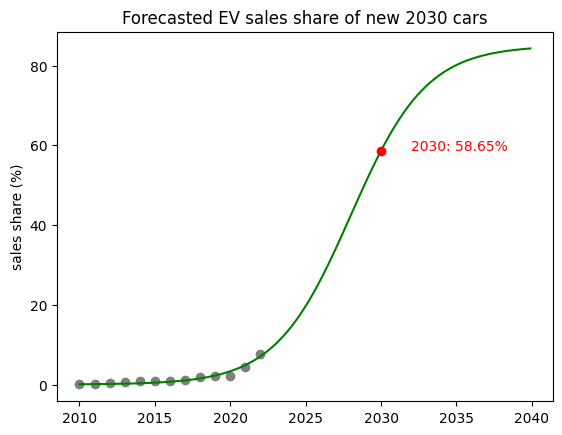

In [234]:
def plot_sigmoid_over_data(x, y, params, region, prediction_year=2030, x_remaining=None, y_remaining=None):
    plt.scatter(x, y, c='gray')
    if x_remaining is not None:
        plt.scatter(x_remaining, y_remaining, c='orange')

    xx = np.arange(2010, 2040, 0.1)
    plt.plot(xx, sigmoid(xx, *params), c='green', label="sigmoid")

    plt.plot(prediction_year, sigmoid(prediction_year, *params), marker='o', c='red')
    plt.text(prediction_year + 2, sigmoid(prediction_year, *params), s=f"{prediction_year}: {round(sigmoid(prediction_year, *params), 2)}%", c='red')

    plt.title(f"Forecasted EV sales share of new {region} cars")
    plt.ylabel("sales share (%)")
    plt.show()
plot_sigmoid_over_data(x, y, best, 2030)

## counts

instead of sales share

In [235]:
counts = iea_global[(iea_global['region'] == "USA") 
                    & (iea_global['parameter'] == "EV sales")
                    & (iea_global['powertrain'] == "BEV")
                    & (iea_global['mode'] == "Cars")]
counts.head()

,region,category,parameter,mode,powertrain,year,unit,value
8769,USA,Historical,EV sales,Cars,BEV,2010,Vehicles,1200.0
8778,USA,Historical,EV sales,Cars,BEV,2011,Vehicles,9800.0
8795,USA,Historical,EV sales,Cars,BEV,2012,Vehicles,15000.0
8804,USA,Historical,EV sales,Cars,BEV,2013,Vehicles,48000.0
8821,USA,Historical,EV sales,Cars,BEV,2014,Vehicles,63000.0


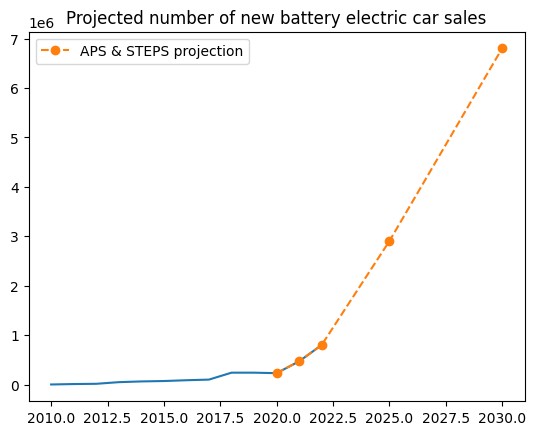

In [236]:
hist_ct = counts[counts['category'] == 'Historical']
hist_ct = hist_ct.set_index('year')

proj = counts[(counts['category'] == 'Projection-APS')]
proj = proj.set_index('year')

plt.plot(hist_ct['value'])
plt.plot(proj['value'], linestyle='--', marker='o', label="APS & STEPS projection")

plt.legend()
plt.title("Projected number of new battery electric car sales")
plt.show()

In [237]:
pcts_all = iea_global[(iea_global['parameter'].str.contains("sales share"))
                  & (iea_global['mode'] == "Cars") & (iea_global['category'].str.contains("Historical"))]
important_countries = pcts_all.loc[pcts_all['value'] > 20]
important_countries

,region,category,parameter,mode,powertrain,year,unit,value
308,Austria,Historical,EV sales share,Cars,EV,2022,percent,22.0
548,Belgium,Historical,EV sales share,Cars,EV,2022,percent,26.0
1679,China,Historical,EV sales share,Cars,EV,2022,percent,29.0
2163,Denmark,Historical,EV sales share,Cars,EV,2021,percent,35.0
2178,Denmark,Historical,EV sales share,Cars,EV,2022,percent,39.0
2473,EU27,Historical,EV sales share,Cars,EV,2022,percent,21.0
3228,Europe,Historical,EV sales share,Cars,EV,2022,percent,21.0
3554,Finland,Historical,EV sales share,Cars,EV,2021,percent,31.0
3561,Finland,Historical,EV sales share,Cars,EV,2022,percent,38.0
3844,France,Historical,EV sales share,Cars,EV,2022,percent,21.0


## Other Regions Analysis (reference classes)

In [238]:
def get_hist_and_proj_for_region(pcts_all, region):
    pcts_country = pcts_all[pcts_all['region'].str.strip() == region]
    hist = pcts_country[pcts_country['category'] == 'Historical']
    hist = hist.set_index('year')
    proj = pcts_country[(pcts_country['category'] == 'Projection-APS')]
    proj = proj.set_index('year')
    return hist, proj

In [239]:
def graph_share_for_region(pcts_all, region):
    hist, proj = get_hist_and_proj_for_region(pcts_all, region)
    plt.plot(hist['value'])
    plt.plot(proj['value'], linestyle='--', marker='o', label="APS & STEPS projection")

    plt.xlabel("year")
    plt.ylabel("sales share (percent)")
    plt.title(f"{region}: Projected EV share of new cars")

    plt.legend()
    plt.show()


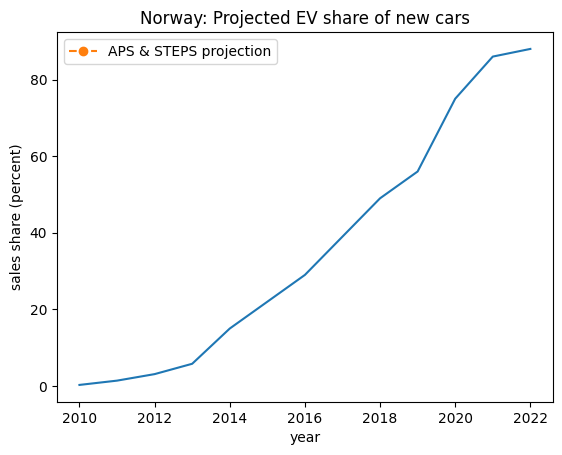

In [240]:
graph_share_for_region(pcts_all, "Norway")

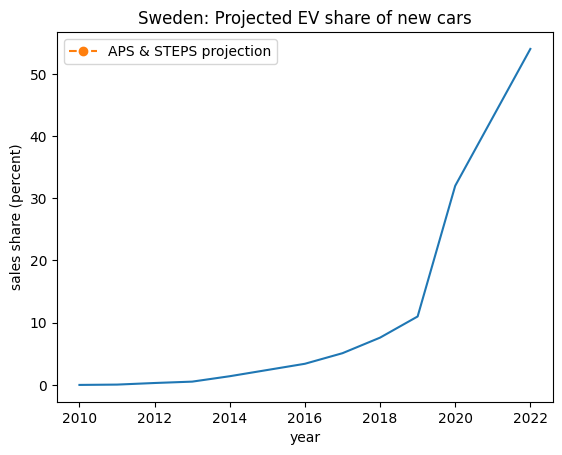

In [241]:
graph_share_for_region(pcts_all, "Sweden")

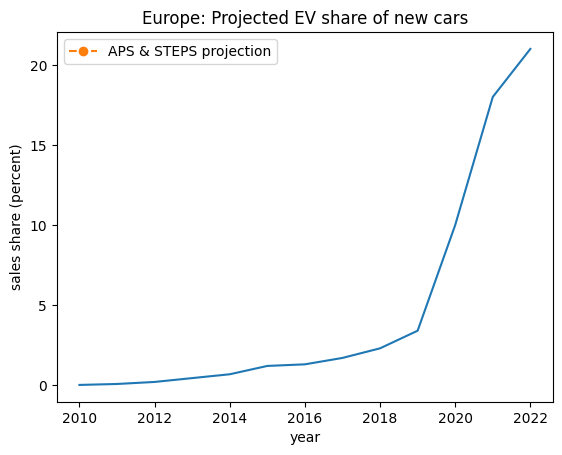

In [242]:
graph_share_for_region(pcts_all, "Europe")

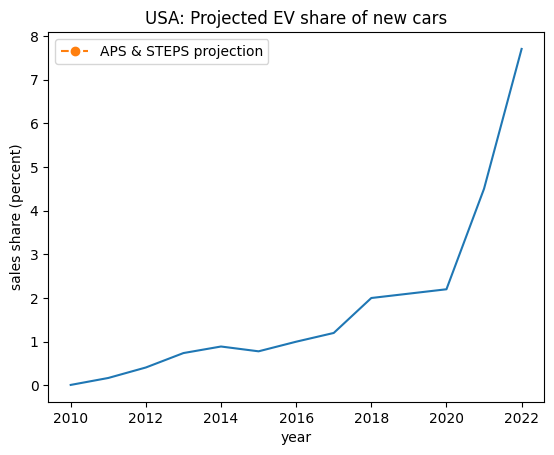

In [243]:
graph_share_for_region(pcts_all, "USA")

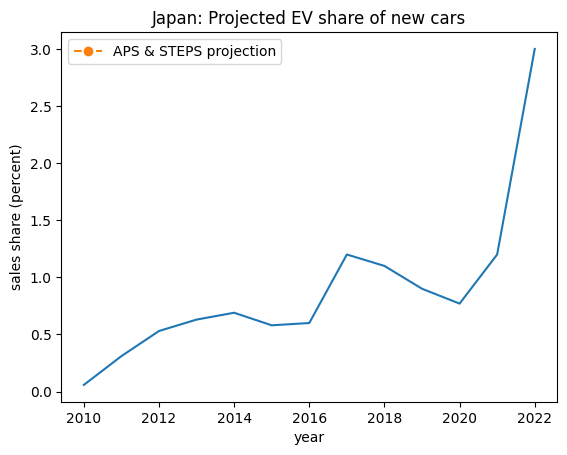

In [244]:
graph_share_for_region(pcts_all, "Japan")

## Norway Modeling

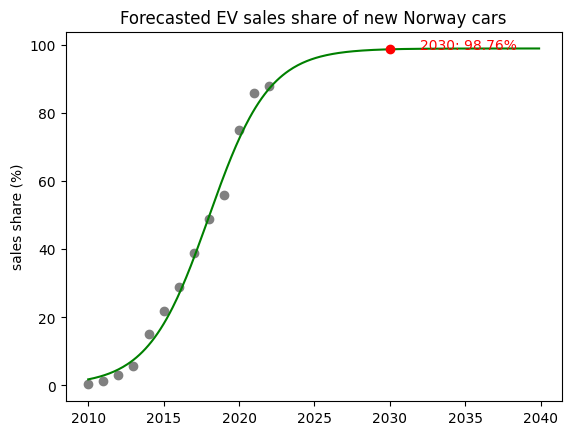

In [245]:
region = 'Norway'
hist, _ = get_hist_and_proj_for_region(pcts_all, region)
x, y = hist.index, hist['value']

best, best_err = fit_sigmoid(x, y)
plot_sigmoid_over_data(x, y, best, region, 2030)

Int64Index([2010, 2011, 2012, 2013, 2014], dtype='int64', name='year') year
2010     0.28
2011     1.40
2012     3.10
2013     5.80
2014    15.00
Name: value, dtype: float64
Int64Index([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], dtype='int64', name='year') year
2015    22.0
2016    29.0
2017    39.0
2018    49.0
2019    56.0
2020    75.0
2021    86.0
2022    88.0
Name: value, dtype: float64


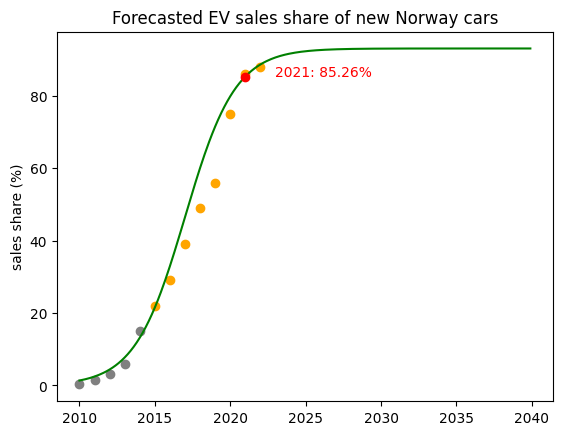

In [246]:
hist, _ = get_hist_and_proj_for_region(pcts_all, region)
x, y = hist.index, hist['value']
co = 5
x, y, x_remaining, y_remaining = x[:co], y[:co], x[co:], y[co:]
print(x, y)
print(x_remaining, y_remaining)

best, best_err = fit_sigmoid(x, y)
plot_sigmoid_over_data(x, y, best, region, 2021, x_remaining, y_remaining)

In [247]:
print(y_remaining[2021])

86.0


## Sweden Modeling

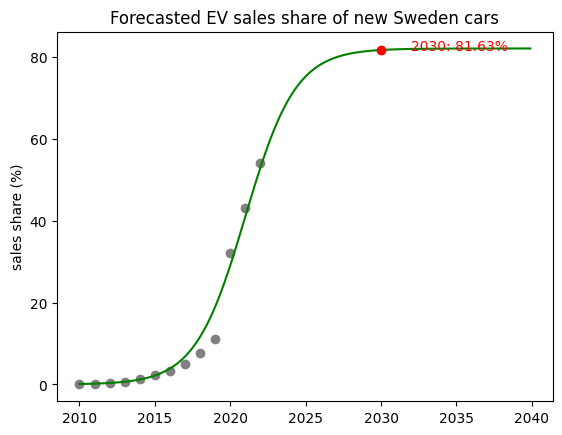

In [248]:
region = 'Sweden'
hist, _ = get_hist_and_proj_for_region(pcts_all, region)
x, y = hist.index, hist['value']

best, best_err = fit_sigmoid(x, y)
plot_sigmoid_over_data(x, y, best, region, 2030)

Int64Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype='int64', name='year') year
2010     0.0013
2011     0.0540
2012     0.3100
2013     0.5300
2014     1.4000
2015     2.4000
2016     3.4000
2017     5.1000
2018     7.6000
2019    11.0000
Name: value, dtype: float64
Int64Index([2020, 2021, 2022], dtype='int64', name='year') year
2020    32.0
2021    43.0
2022    54.0
Name: value, dtype: float64


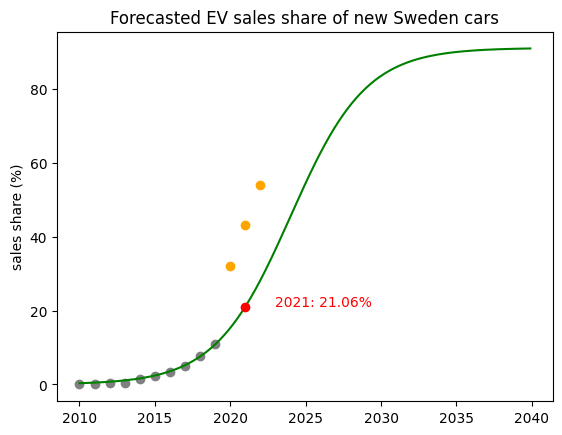

In [249]:
hist, _ = get_hist_and_proj_for_region(pcts_all, region)
x, y = hist.index, hist['value']
co = 10
x, y, x_remaining, y_remaining = x[:co], y[:co], x[co:], y[co:]
print(x, y)
print(x_remaining, y_remaining)

best, best_err = fit_sigmoid(x, y)
plot_sigmoid_over_data(x, y, best, region, 2021, x_remaining, y_remaining)

## EU Modeling

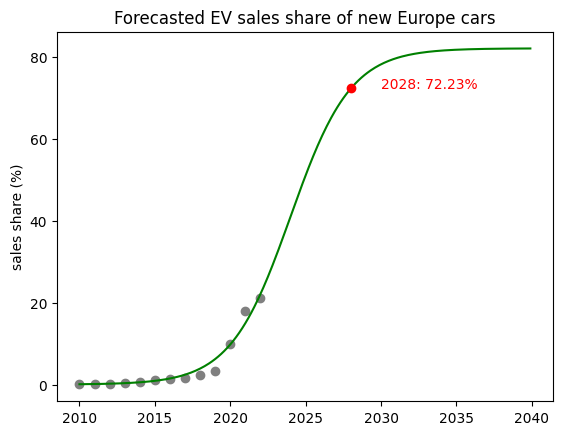

In [250]:
region = 'Europe'
hist, _ = get_hist_and_proj_for_region(pcts_all, region)
x, y = hist.index, hist['value']

best, best_err = fit_sigmoid(x, y)
plot_sigmoid_over_data(x, y, best, region, 2028)

Input Data
year
2010    0.014
2011    0.073
2012    0.200
2013    0.440
2014    0.680
2015    1.200
2016    1.300
2017    1.700
2018    2.300
2019    3.400
Name: value, dtype: float64
Real future
year
2020    10.0
2021    18.0
2022    21.0
Name: value, dtype: float64


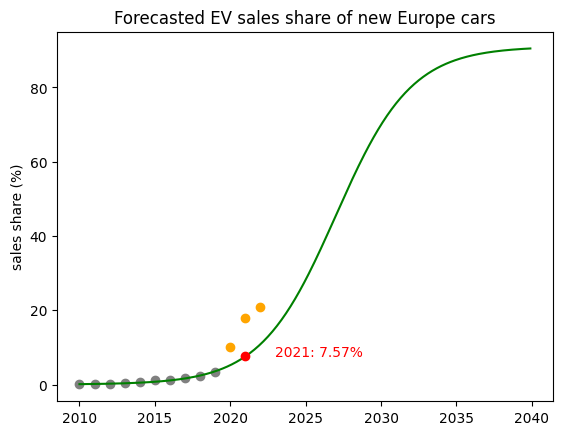

In [251]:
hist, _ = get_hist_and_proj_for_region(pcts_all, region)
x, y = hist.index, hist['value']
co = 10
x, y, x_remaining, y_remaining = x[:co], y[:co], x[co:], y[co:]
print("Input Data")
print(y)
print("Real future")
print(y_remaining)

best, best_err = fit_sigmoid(x, y)
plot_sigmoid_over_data(x, y, best, region, 2021, x_remaining, y_remaining)

## Is the EU lagged a good model for the US?

Text(0.5, 1.0, 'EV Car sales percentage in US lagging (blue) vs Europe (present)')

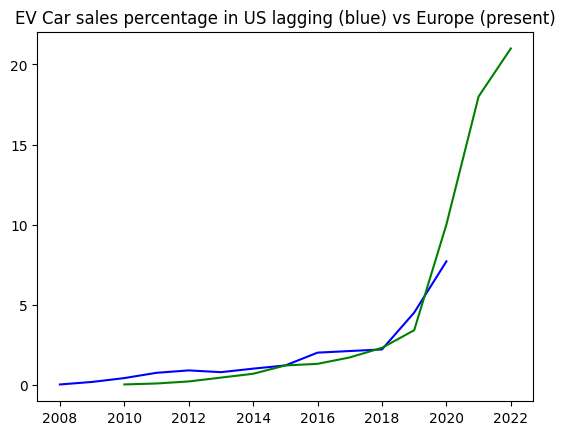

In [252]:
region = "USA"
hist, _ = get_hist_and_proj_for_region(pcts_all, region)
x, y = hist.index, hist['value']
region = "Europe"
hist, _ = get_hist_and_proj_for_region(pcts_all, region)
x_eu, y_eu = hist.index, hist['value']
x = x - 2
plt.plot(x, y, c='blue')
plt.plot(x_eu, y_eu, c='green')
plt.title("EV Car sales percentage in US lagging (blue) vs Europe (present)")

## China Modeling

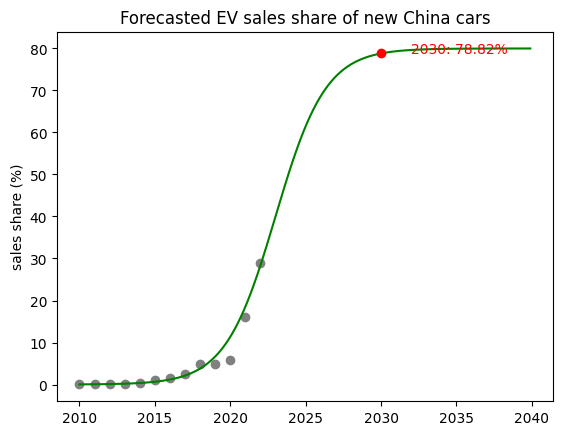

In [253]:
region = 'China'
hist, _ = get_hist_and_proj_for_region(pcts_all, region)
x, y = hist.index, hist['value']

best, best_err = fit_sigmoid(x, y)
plot_sigmoid_over_data(x, y, best, region, 2030)

Input Data
year
2010    0.010
2011    0.034
2012    0.073
2013    0.095
2014    0.400
2015    1.000
2016    1.500
2017    2.400
2018    4.900
Name: value, dtype: float64
Real future
year
2019     5.0
2020     5.8
2021    16.0
2022    29.0
Name: value, dtype: float64


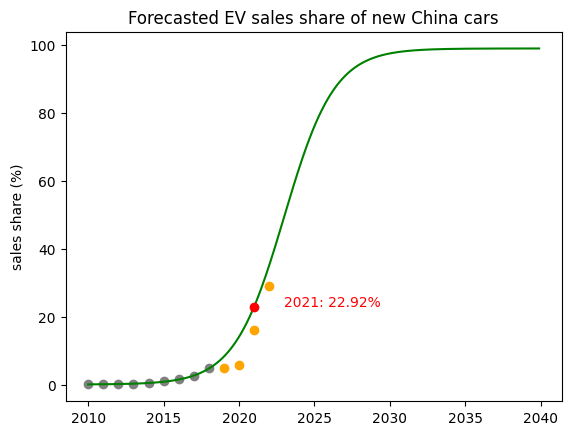

In [254]:
hist, _ = get_hist_and_proj_for_region(pcts_all, region)
x, y = hist.index, hist['value']
co = 9
x, y, x_remaining, y_remaining = x[:co], y[:co], x[co:], y[co:]
print("Input Data")
print(y)
print("Real future")
print(y_remaining)

best, best_err = fit_sigmoid(x, y)
plot_sigmoid_over_data(x, y, best, region, 2021, x_remaining, y_remaining)